## Load Monthly Partitions (Data Lake View)

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import seaborn as sns

files = sorted(glob.glob("../data/nyc_taxi/yellow_tripdata_*.csv"))

dfs = []
for f in files:
    month = f.split("_")[-1].replace(".csv", "")
    df_m = pd.read_csv(f)
    df_m["partition"] = month
    dfs.append(df_m)

df = pd.concat(dfs, ignore_index=True)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,partition,RatecodeID
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1.0,N,-73.974785,...,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,2015-01,NaN
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1.0,N,-73.994415,...,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,2015-01,NaN
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1.0,N,-73.951820,...,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,2015-01,NaN
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1.0,N,-74.004326,...,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,2015-01,NaN
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1.0,N,-74.004181,...,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,2015-01,NaN


## Ingestion Drift Metrics

In [2]:
ingestion_metrics = []

for p, g in df.groupby("partition"):
    ingestion_metrics.append({
        "partition": p,
        "rows": len(g),
        "missing_rate": g.isna().mean().mean()
    })

ingest_df = pd.DataFrame(ingestion_metrics)
ingest_df


,partition,rows,missing_rate
0,2015-01,12748986,0.047619
1,2016-01,10906858,0.047619
2,2016-02,11382049,0.047619
3,2016-03,12210952,0.047619


## Ingestion Drift Plot

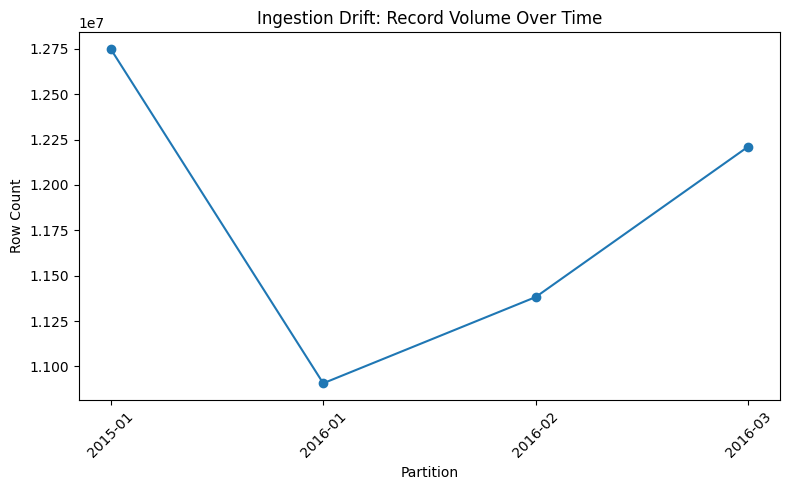

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ingest_df["partition"], ingest_df["rows"], marker="o")
plt.xticks(rotation=45)
plt.title("Ingestion Drift: Record Volume Over Time")
plt.ylabel("Row Count")
plt.xlabel("Partition")
plt.tight_layout()
plt.show()

## Feature Distribution Drift (Taxi)

In [4]:
from scipy.stats import wasserstein_distance

base_partition = ingest_df["partition"].iloc[0]

base_df = df[df["partition"] == base_partition]

drift_scores = []

numeric_cols = [
    "trip_distance",
    "fare_amount",
    "total_amount"
]

for p, g in df.groupby("partition"):
    if p == base_partition:
        continue
    for col in numeric_cols:
        dist = wasserstein_distance(
            base_df[col].dropna(),
            g[col].dropna()
        )
        drift_scores.append({
            "partition": p,
            "feature": col,
            "wasserstein_distance": dist
        })

drift_nyc = pd.DataFrame(drift_scores)
drift_nyc.head()


,partition,feature,wasserstein_distance
0,2016-01,trip_distance,9.040766
1,2016-01,fare_amount,0.584690
2,2016-01,total_amount,1.138285
3,2016-02,trip_distance,8.545021
4,2016-02,fare_amount,0.510613


## Drift Heatmap

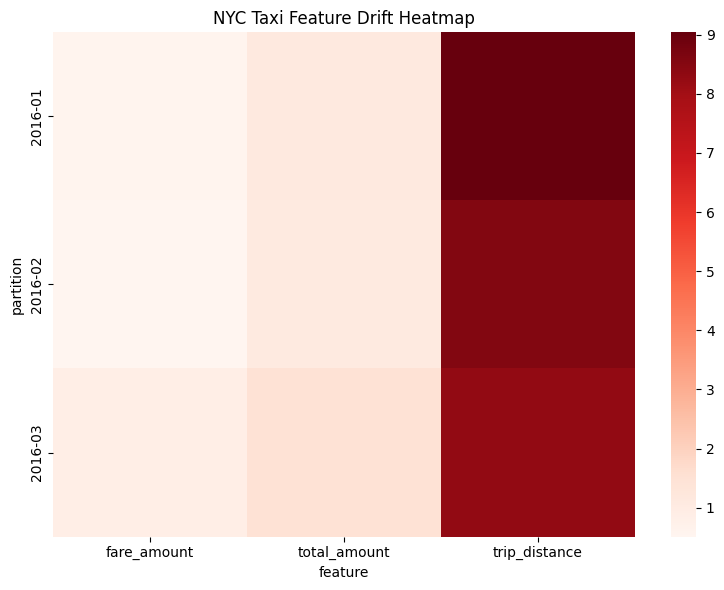

: 

In [ ]:
pivot = drift_nyc.pivot(
    index="partition",
    columns="feature",
    values="wasserstein_distance"
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, cmap="Reds", annot=False)
plt.title("NYC Taxi Feature Drift Heatmap")
plt.tight_layout()
plt.show()